<a href="https://colab.research.google.com/github/robins645/ML_Project/blob/main/Anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow numpy matplotlib


In [1]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define where to save checkpoints
checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Define checkpoint callback
checkpoint_path = os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_valacc_{val_accuracy:.2f}.weights.h5')
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,      # Save only model weights to save disk space
    save_best_only=False,        # You can set to True once you track the best validation accuracy
    monitor='val_accuracy',      # Track validation accuracy
    verbose=1
)

In [2]:
pip install pandas scikit-learn pillow torch torchvision

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
dataset_path = '/content/drive/MyDrive/blood_detection'

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),     # Adjust to your model's required input size
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

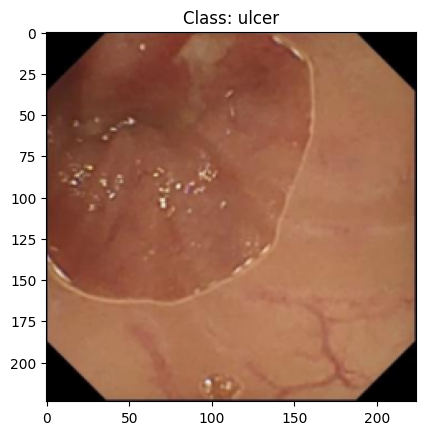

In [6]:
import matplotlib.pyplot as plt

images, labels = next(iter(dataloader))
plt.imshow(images[0].permute(1, 2, 0))
plt.title(f'Class: {dataset.classes[labels[0]]}')
plt.show()


In [7]:
import tensorflow as tf

# Parameters
batch_size = 32
img_height = 224
img_width = 224
seed = 123

# Load training dataset (70% of data)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,          # 30% reserved for validation
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load validation dataset (30% of data)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get class names for reference
class_names = train_ds.class_names
print("Classes found:", class_names)

# Prefetch for performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 1514 files belonging to 4 classes.
Using 1060 files for training.
Found 1514 files belonging to 4 classes.
Using 454 files for validation.
Classes found: ['blood - fresh', 'erythema', 'polyp', 'ulcer']


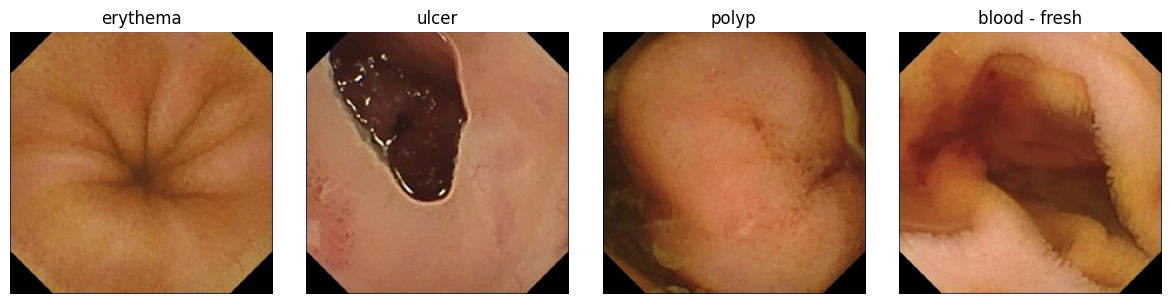

In [11]:
import matplotlib.pyplot as plt
import os
from PIL import Image
dataset_path = '/content/drive/MyDrive/blood_detection'
img_height, img_width = 224, 224  # Resize images for uniform display

# List all subfolders (each class folder)
class_folders = [f for f in os.listdir(dataset_path)
                 if os.path.isdir(os.path.join(dataset_path, f))]

plt.figure(figsize=(12, 3))

for i, folder in enumerate(class_folders):
    folder_path = os.path.join(dataset_path, folder)
    # List image files inside the folder
    image_files = [f for f in os.listdir(folder_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print(f"No images found in folder: {folder}")
        continue
    # Load the first image found and resize
    image_path = os.path.join(folder_path, image_files[0])
    img = Image.open(image_path).resize((img_width, img_height))
    # Display the image with the folder name as title
    plt.subplot(1, len(class_folders), i + 1)
    plt.imshow(img)
    plt.title(folder)
    plt.axis('off')

plt.tight_layout()
plt.show()

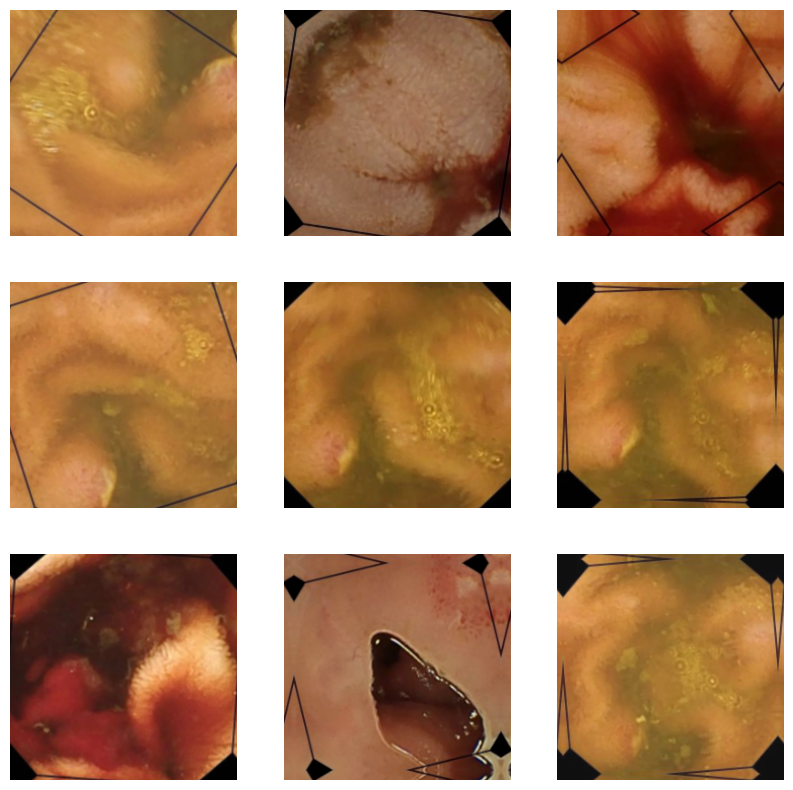

In [12]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Define the augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1)
])

# Example: Apply to a batch to preview augmentations
for images, _ in train_ds.take(1):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented_img = data_augmentation(images)[i].numpy().astype("uint8")
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_img)
        plt.axis("off")
    plt.show()


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Image parameters and number of classes
img_height, img_width = 224, 224
num_classes = 4

# Ensure 'data_augmentation' exists from your previous step

# Load the base ResNet50 model
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False  # Freeze base layers during initial training

inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)  # ResNet50 preprocessing
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [15]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │      8,196 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
# Number of epochs to train
epochs = 20

# Train the model with checkpointing and validation
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint_cb]   # Your checkpoint callback from Step 1
)


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5973 - loss: 1.1495
Epoch 1: saving model to ./checkpoints/model_epoch_01_valacc_0.85.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 342s 10s/step - accuracy: 0.6010 - loss: 1.1395 - val_accuracy: 0.8458 - val_loss: 0.4476
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8868 - loss: 0.3178
Epoch 2: saving model to ./checkpoints/model_epoch_02_valacc_0.93.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 312s 8s/step - accuracy: 0.8873 - loss: 0.3168 - val_accuracy: 0.9273 - val_loss: 0.2659
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9215 - loss: 0.2206
Epoch 3: saving model to ./checkpoints/model_epoch_03_valacc_0.93.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 328s 8s/step - accuracy: 0.9217 - loss: 0.2200 - val_accuracy: 0.9273 - val_loss: 0.2183
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9371 - loss: 0.1701
Epoch 4: saving model to ./checkpoints/model_epoch_04_valacc_0.92.weights.h5
34/34 ━━━━━

In [17]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest:
    print(f"Loading weights from {latest}")
    model.load_weights(latest)

In [18]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    subset="validation",  # Or use your own held-out test directory
    validation_split=0.3,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")


Found 1514 files belonging to 4 classes.
Using 454 files for validation.
15/15 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - accuracy: 0.9757 - loss: 0.0775
Test accuracy: 0.9846


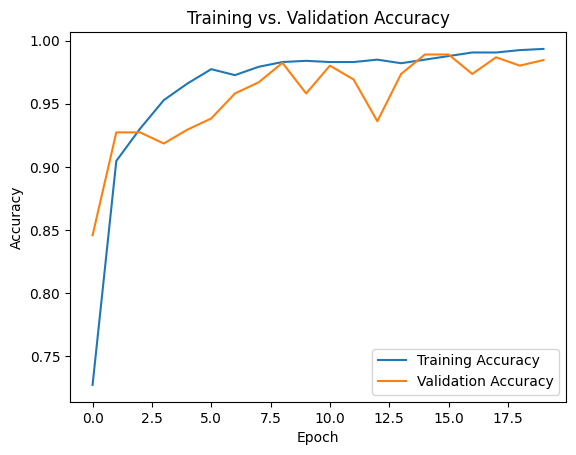

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


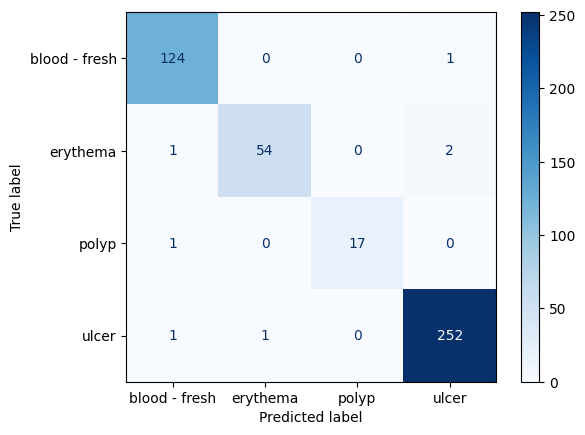

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Gather predicted and true labels
y_pred = []
y_true = []
for images, labels in test_ds:
    preds = np.argmax(model.predict(images), axis=1)
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [30]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to your image file (update this path)
img_path = '/content/d369e4f163df4aba_13332.jpg'

# Load and resize image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)

# Expand dimensions: model expects batch format
img_array = np.expand_dims(img_array, axis=0)

# Apply ResNet50's preprocessing
img_array = tf.keras.applications.resnet.preprocess_input(img_array)


In [31]:
# Predict the class probabilities
predictions = model.predict(img_array)

# Get the most probable class
predicted_class = np.argmax(predictions, axis=1)[0]

print(f"Predicted class index: {predicted_class}")
print(f"Predicted class label: {class_names[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Predicted class index: 0
Predicted class label: blood - fresh


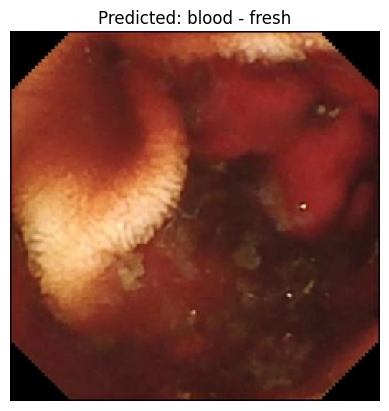

In [32]:
import matplotlib.pyplot as plt

plt.imshow(image.load_img(img_path, target_size=(224, 224)))
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis('off')
plt.show()
